#**Classification sur la maintenance prédictive de machines**

L'objectif de cette étude est de pouvoir prédire une future panne des machines pour pouvoir anticiper la maintenance. Pour cela, nous allons procéder à une classification binaire représentant si oui ou non il y a eu une panne, ainsi qu'une classification multiclasse pour savoir à quelle type de panne on a affaire. Nous disposons d'une base de données constituée de 10000 observations pour 10 variables que sont les suivantes :



*   **UID** : identifiant allant de 1 à 10000.
*   **Product ID** : le numéro de série de la machine.
*   **Type** : correspond à la qualité de produit avec L (faible), M (moyenne) et H(élevée).
*   **Air temperature [K]** : correspond à la température de l'air en Kelvin.
*   **Process temperature [K]** : correspond à la température du processus en Kelvin.
*   **Rotational Speed [rpm]** : correspond à la vitesse de rotation claculée en tours par minute à une puissance de 2860 W.
*   **Torque [Nm]** : correspond au couple calculé en Newton mètre (Nm).
*   **Tool wear [min]** : correspond à l'usure de l'outil en minutes. Les variantes H/M/L ajoutent respectivement 5/3/2 minutes au processus.
*   **Target** : Variable cible binaire prenant les valeurs 0 (pas d'échec) et 1 (échec).
*   **Failure Type** : Variable cible catégorielle prenant en compte les différents types d'échec.















##**1) Analyse Exploratoire**

###Chargement de packages

In [1]:
import pandas as pd
from google.colab import drive
import scipy.stats
from scipy.stats import shapiro
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from imblearn.over_sampling import RandomOverSampler
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.metrics import accuracy_score, confusion_matrix
from sklearn.svm import SVC
from sklearn.svm import LinearSVC
from sklearn.linear_model import SGDClassifier



###Chargement du dataset

In [2]:
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


In [3]:
chemin_fichier = '/content/drive/MyDrive/Dossier_SVM/predictive_maintenance.csv'
base = pd.read_csv(chemin_fichier, sep=",")
base

,UDI,Product ID,Type,Air temperature [K],Process temperature [K],Rotational speed [rpm],Torque [Nm],Tool wear [min],Target,Failure Type
0,1,M14860,M,298.1,308.6,1551,42.8,0,0,No Failure
1,2,L47181,L,298.2,308.7,1408,46.3,3,0,No Failure
2,3,L47182,L,298.1,308.5,1498,49.4,5,0,No Failure
3,4,L47183,L,298.2,308.6,1433,39.5,7,0,No Failure
4,5,L47184,L,298.2,308.7,1408,40.0,9,0,No Failure
...,...,...,...,...,...,...,...,...,...,...
9995,9996,M24855,M,298.8,308.4,1604,29.5,14,0,No Failure
9996,9997,H39410,H,298.9,308.4,1632,31.8,17,0,No Failure
9997,9998,M24857,M,299.0,308.6,1645,33.4,22,0,No Failure
9998,9999,H39412,H,299.0,308.7,1408,48.5,25,0,No Failure


In [4]:
#changement des noms des colonnes
nouveaux_noms = ['UDI', 'Product_ID', 'Type', 'Air_temperature', 'Process_temperature', 'Rotational_speed', 'Torque', 'Tool_wear', 'Target', 'Failure_Type']
base.columns = nouveaux_noms
base.head(3)

,UDI,Product_ID,Type,Air_temperature,Process_temperature,Rotational_speed,Torque,Tool_wear,Target,Failure_Type
0,1,M14860,M,298.1,308.6,1551,42.8,0,0,No Failure
1,2,L47181,L,298.2,308.7,1408,46.3,3,0,No Failure
2,3,L47182,L,298.1,308.5,1498,49.4,5,0,No Failure


On a changé les noms des variables pour faciliter la suite de l'analyse.

In [5]:
#Vérification du type de la base de données :
type(base)

pandas.core.frame.DataFrame

On a bien affaire à un data frame.

In [6]:
#Vérification du nombre de lignes et de colonnes:
base.shape

(10000, 10)

L'échantillon est constitué de 100000 observations pour 10 variables (dont deux targets).

In [7]:
#Vérification des valeurs manquantes
base.isna().sum()

UDI                    0
Product_ID             0
Type                   0
Air_temperature        0
Process_temperature    0
Rotational_speed       0
Torque                 0
Tool_wear              0
Target                 0
Failure_Type           0
dtype: int64

Il n'y a pas de valeurs manquantes.

In [8]:
#Vérification des types des variables
base.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 10 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   UDI                  10000 non-null  int64  
 1   Product_ID           10000 non-null  object 
 2   Type                 10000 non-null  object 
 3   Air_temperature      10000 non-null  float64
 4   Process_temperature  10000 non-null  float64
 5   Rotational_speed     10000 non-null  int64  
 6   Torque               10000 non-null  float64
 7   Tool_wear            10000 non-null  int64  
 8   Target               10000 non-null  int64  
 9   Failure_Type         10000 non-null  object 
dtypes: float64(3), int64(4), object(3)
memory usage: 781.4+ KB


Il y a 4 variables qui sont des integer, 3 qui sont des nombres réels et 3 autres qui sont des variables catégorielles.
Il y a des changements a faire en ce qui concerne les types des variables notamment pour Failure_Type et Type. Il y a de plus des variables inutiles à supprimer comme UDI et Product_ID.

In [9]:
#Identification des modalités de la variables Failure_Type:
base.Failure_Type.value_counts()

No Failure                  9652
Heat Dissipation Failure     112
Power Failure                 95
Overstrain Failure            78
Tool Wear Failure             45
Random Failures               18
Name: Failure_Type, dtype: int64

In [10]:
#Identification des modalités de la variables Type:
base.Type.value_counts()

L    6000
M    2997
H    1003
Name: Type, dtype: int64

In [11]:
#Identification des modalités de la variables Target:
base.Target.value_counts()

0    9661
1     339
Name: Target, dtype: int64

On a vérifié les différentes modalités des différentes variables catégorielles.

###Statistiques descriptives des variables quantitatives

In [12]:
#création d'une base ne comportant que les variables quantitatives:
base_drop = base.drop(columns=['UDI', 'Product_ID', 'Type', 'Target', 'Failure_Type'])
base_drop.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 5 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   Air_temperature      10000 non-null  float64
 1   Process_temperature  10000 non-null  float64
 2   Rotational_speed     10000 non-null  int64  
 3   Torque               10000 non-null  float64
 4   Tool_wear            10000 non-null  int64  
dtypes: float64(3), int64(2)
memory usage: 390.8 KB


In [13]:
#affichage des différentes statistiques descriptives des variables quantitatives:
base_drop.describe()

,Air_temperature,Process_temperature,Rotational_speed,Torque,Tool_wear
count,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000
mean,300.004930,310.005560,1538.776100,39.986910,107.951000
std,2.000259,1.483734,179.284096,9.968934,63.654147
min,295.300000,305.700000,1168.000000,3.800000,0.000000
25%,298.300000,308.800000,1423.000000,33.200000,53.000000
50%,300.100000,310.100000,1503.000000,40.100000,108.000000
75%,301.500000,311.100000,1612.000000,46.800000,162.000000
max,304.500000,313.800000,2886.000000,76.600000,253.000000


On voit ici, qu'il y a des différences d'échelle entre les variables, les standardiser sera donc important. Au vu de leur moyenne la variable Torque et Tool_wear dispose d'un écart type important contrairement aux variables Air_temperature et Process_temperature.

In [14]:
#Vérification de la normalité des variables quantitatives
# On crée un tableau pour stocker les résultats
resultats_tests = pd.DataFrame(columns=['Variable', 'Statistique de test', 'p-value', 'Suit loi normale (5%)'])

# Boucle pour effectuer le shapiro test sur chaque variable:
for colonne in base_drop.columns:
    # Effectuez le test de normalité de Shapiro-Wilk
    statistique, p_value = shapiro(base_drop[colonne])

    # Ajoutez les résultats au tableau
    suit_loi_normale = 'Oui' if p_value > 0.05 else 'Non'
    resultats_tests = resultats_tests.append({
        'Variable': colonne,
        'Statistique de test': statistique,
        'p-value': p_value,
        'Suit loi normale (5%)': suit_loi_normale
    }, ignore_index=True)

# Affichez le tableau des résultats
resultats_tests


/usr/local/lib/python3.10/dist-packages/scipy/stats/_morestats.py:1882: UserWarning: p-value may not be accurate for N > 5000.
  warnings.warn("p-value may not be accurate for N > 5000.")
<ipython-input-14-31d34d6fa60f>:12: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  resultats_tests = resultats_tests.append({
/usr/local/lib/python3.10/dist-packages/scipy/stats/_morestats.py:1882: UserWarning: p-value may not be accurate for N > 5000.
  warnings.warn("p-value may not be accurate for N > 5000.")
<ipython-input-14-31d34d6fa60f>:12: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  resultats_tests = resultats_tests.append({
/usr/local/lib/python3.10/dist-packages/scipy/stats/_morestats.py:1882: UserWarning: p-value may not be accurate for N > 5000.
  warnings.warn("p-value may not be accurate for N > 5000.")
<ipython

,Variable,Statistique de test,p-value,Suit loi normale (5%)
0,Air_temperature,0.980775,1.352803e-34,Non
1,Process_temperature,0.992393,1.130353e-22,Non
2,Rotational_speed,0.864520,0.000000e+00,Non
3,Torque,0.999770,3.560868e-01,Oui
4,Tool_wear,0.959917,0.000000e+00,Non


Il n'y a qu'une seule variable quantitative qui suit une loi normale (Torque). Nous pouvons le constater graphiquement à l'aide des histogrammes ci_dessous.

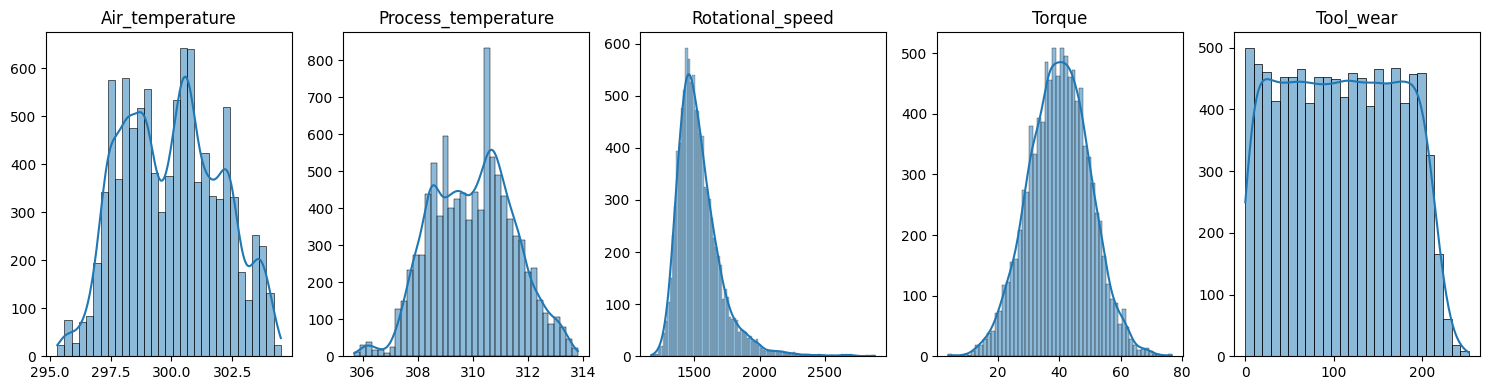

In [15]:
#Affichage des histogrammes des variables quantitatives:
fig, axes = plt.subplots(nrows=1, ncols=len(base_drop.columns), figsize=(15, 4))

for i, colonne in enumerate(base_drop.columns):
    sns.histplot(base_drop[colonne], ax=axes[i], kde=True)
    axes[i].set_title(colonne)
    axes[i].set_xlabel('')
    axes[i].set_ylabel('')

# Ajustement de l'espacement entre les sous-graphiques
plt.tight_layout()

# Affichage des histogrammes
plt.show()

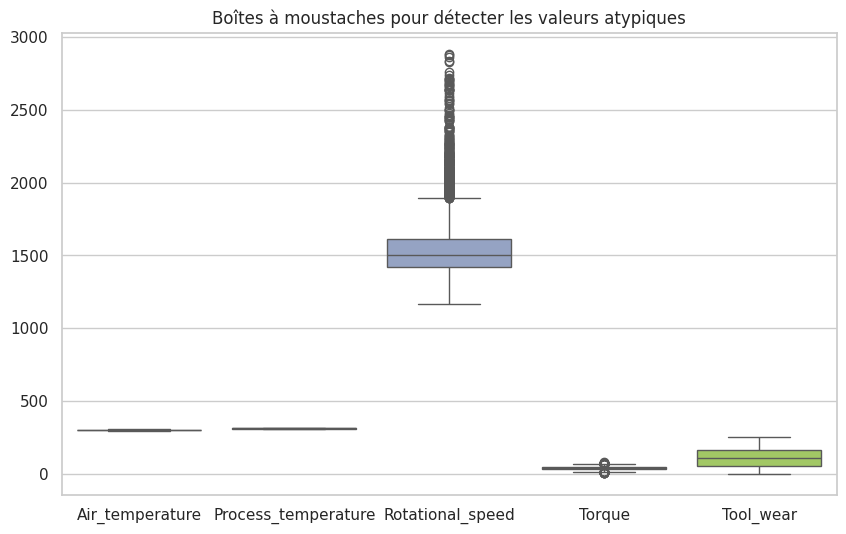

In [16]:
#boxplot des variables quantitatives:
sns.set(style="whitegrid")
plt.figure(figsize=(10, 6))
sns.boxplot(data=base_drop, orient="v", palette="Set2")
plt.title("Boîtes à moustaches pour détecter les valeurs atypiques")
plt.show()

In [17]:
# Calcul de l'écart interquartile (IQR) pour chaque variable
Q1 = base_drop.quantile(0.25)
Q3 = base_drop.quantile(0.75)
IQR = Q3 - Q1

# Seuil pour considérer les valeurs comme atypiques (1,5 fois l'IQR)
seuil_atypique = 1.5

# Identification des indices des valeurs atypiques pour chaque variable
indices_atypiques = ((base_drop < (Q1 - seuil_atypique * IQR)) | (base_drop > (Q3 + seuil_atypique * IQR))).any(axis=1)

# Affichage des lignes du DataFrame qui contiennent des valeurs atypiques
print(base_drop[indices_atypiques])

      Air_temperature  Process_temperature  Rotational_speed  Torque  \
14              298.6                309.2              2035    19.6   
50              298.9                309.1              2861     4.6   
70              298.9                309.0              1924    22.6   
101             298.8                308.8              1991    20.7   
155             298.4                308.2              1987    19.8   
...               ...                  ...               ...     ...   
9871            298.9                309.8              1947    21.7   
9886            298.8                309.6              1903    22.3   
9926            298.5                308.6              1897    20.2   
9939            298.3                308.1              2636    12.8   
9974            298.6                308.2              1361    68.2   

      Tool_wear  
14           40  
50          143  
70          193  
101          59  
155         198  
...         ...  
9871     

In [18]:
# Remplacement des valeurs atypiques par la médiane de chaque variable
base_corrected = base_drop.copy()
base_corrected[indices_atypiques] = base_drop.median()

# Affichage du DataFrame corrigé
print(base_corrected)

      Air_temperature  Process_temperature  Rotational_speed  Torque  \
0               298.1                308.6              1551    42.8   
1               298.2                308.7              1408    46.3   
2               298.1                308.5              1498    49.4   
3               298.2                308.6              1433    39.5   
4               298.2                308.7              1408    40.0   
...               ...                  ...               ...     ...   
9995            298.8                308.4              1604    29.5   
9996            298.9                308.4              1632    31.8   
9997            299.0                308.6              1645    33.4   
9998            299.0                308.7              1408    48.5   
9999            299.0                308.7              1500    40.2   

      Tool_wear  
0             0  
1             3  
2             5  
3             7  
4             9  
...         ...  
9995     

On a décelé et corrigé les valeurs atypiques de 459 observations en les remplaçant par la médiane.

In [19]:
base_quali = base[['Target', 'Failure_Type', 'Type']].copy()
base_quali.head(5)

,Target,Failure_Type,Type
0,0,No Failure,M
1,0,No Failure,L
2,0,No Failure,L
3,0,No Failure,L
4,0,No Failure,L


On crée la base comportant que les variables qualitatives avant de la concaténer avec les variables quantitatives.

In [20]:
#Concaténation horizontale des variables qualitatves avec la base corrigée des variables quantitatives.
base2 = pd.concat([base_quali, base_corrected], axis=1)
print(base2)

      Target Failure_Type Type  Air_temperature  Process_temperature  \
0          0   No Failure    M            298.1                308.6   
1          0   No Failure    L            298.2                308.7   
2          0   No Failure    L            298.1                308.5   
3          0   No Failure    L            298.2                308.6   
4          0   No Failure    L            298.2                308.7   
...      ...          ...  ...              ...                  ...   
9995       0   No Failure    M            298.8                308.4   
9996       0   No Failure    H            298.9                308.4   
9997       0   No Failure    M            299.0                308.6   
9998       0   No Failure    H            299.0                308.7   
9999       0   No Failure    M            299.0                308.7   

      Rotational_speed  Torque  Tool_wear  
0                 1551    42.8          0  
1                 1408    46.3          3  
2  

###Statistiques descriptives des variables qualitatives

In [21]:
pd.crosstab(base_quali.Type, "freq")

col_0,freq
Type,
H,1003
L,6000
M,2997


On voit ici la répartition des modalité de la variables Type.

<Axes: xlabel='Type'>

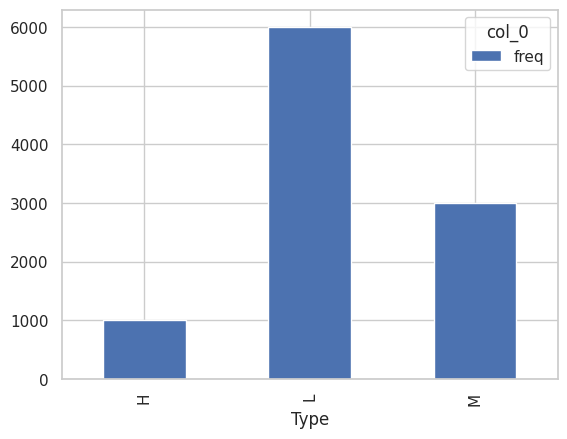

In [22]:
Type = pd.crosstab(base_quali.Type, "freq")
Type.plot.bar()

In [23]:
scipy.stats.chisquare(Type)

Power_divergenceResult(statistic=array([3796.4054]), pvalue=array([0.]))

On voit que l'échantillon est déséquilibré en terme de qualité de produit. Il y a 60% de machines de mauvaise qualité pour 10% de bonne et 30% de moyenne.

In [24]:
pd.crosstab(base_quali.Target, "freq")

col_0,freq
Target,
0,9661
1,339


<Axes: xlabel='Target'>

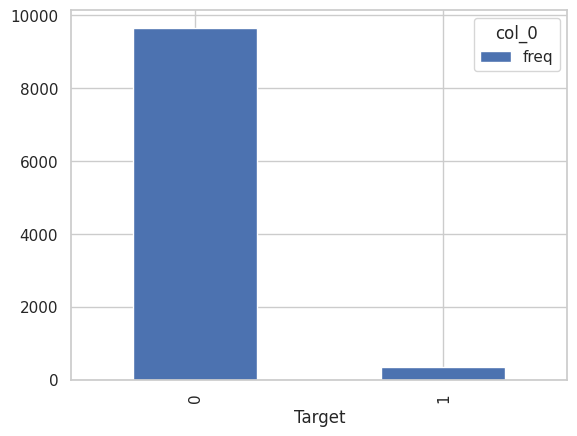

In [25]:
Target = pd.crosstab(base_quali.Target, "freq")
Target.plot.bar()

In [26]:
scipy.stats.chisquare(Target)

Power_divergenceResult(statistic=array([8689.9684]), pvalue=array([0.]))

On observe un déséquilibre en ce qui concerne les deux classes. 3% d'échec pour 97% de non-échec. Il faudra penser à rééquilibrer la classe minoritaire (Oversampling, SMOTE).

In [27]:
pd.crosstab(base_quali.Failure_Type, "freq")

col_0,freq
Failure_Type,
Heat Dissipation Failure,112
No Failure,9652
Overstrain Failure,78
Power Failure,95
Random Failures,18
Tool Wear Failure,45


<Axes: xlabel='Failure_Type'>

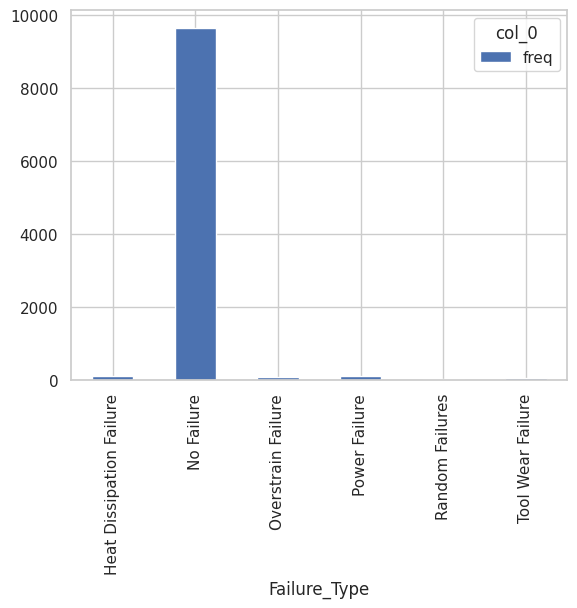

In [28]:
Failure = pd.crosstab(base_quali.Failure_Type, "freq")
Failure.plot.bar()

In [29]:
scipy.stats.chisquare(Failure)

Power_divergenceResult(statistic=array([45914.6636]), pvalue=array([0.]))

On observe également un déséquilibre entre la classe No Failure et les autres classes. 97% pour 3% d'échec.

###Analyse des corrélations

<Axes: >

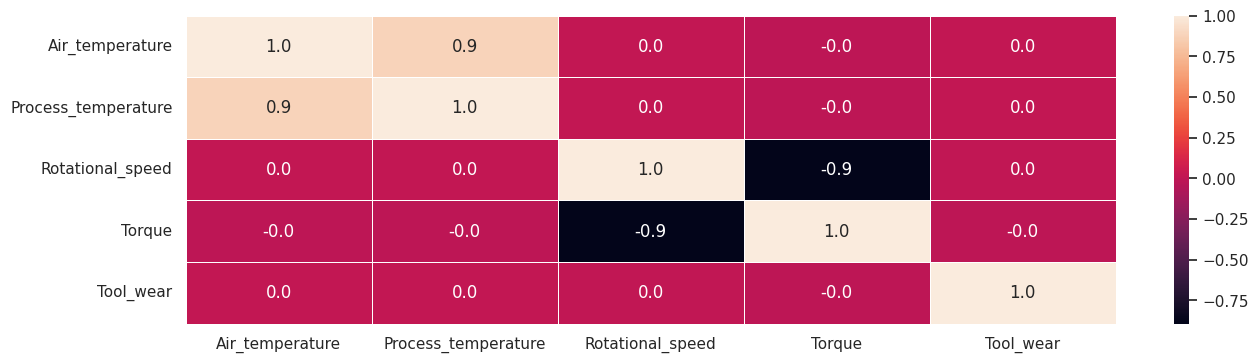

In [30]:
#correlation map
f,ax = plt.subplots(figsize=(15, 4))
sns.heatmap(base_corrected.corr(), annot=True, linewidths=.5, fmt= '.1f',ax=ax)

On peut voir que les variables Air_temperature et Process_temperature sont fortement corrélées de même pour les variables Rotational_speed et Torque où celles-ci sont anticorrélées. Il va falloir procéder à une suppression de variables pour ne pas qu'il y ait un surplus d'informations lors des modélisations.

In [31]:
t = pd.crosstab(base_quali.Type, base_quali.Target)
scipy.stats.chi2_contingency(t)

Chi2ContingencyResult(statistic=13.75171680114931, pvalue=0.0010324110359454081, dof=2, expected_freq=array([[ 968.9983,   34.0017],
       [5796.6   ,  203.4   ],
       [2895.4017,  101.5983]]))

Il y a bien une dépendance significative entre la variables Target et Type (p-value inférieur à 0.05).

In [32]:
d = pd.crosstab(base_quali.Type, base_quali.Failure_Type)
scipy.stats.chi2_contingency(d)

Chi2ContingencyResult(statistic=47.231325744826826, pvalue=8.570442384573732e-07, dof=10, expected_freq=array([[1.1233600e+01, 9.6809560e+02, 7.8234000e+00, 9.5285000e+00,
        1.8054000e+00, 4.5135000e+00],
       [6.7200000e+01, 5.7912000e+03, 4.6800000e+01, 5.7000000e+01,
        1.0800000e+01, 2.7000000e+01],
       [3.3566400e+01, 2.8927044e+03, 2.3376600e+01, 2.8471500e+01,
        5.3946000e+00, 1.3486500e+01]]))

De même entre les variables Type et Failure_Type.

###Préparation de la base de données pour la modélisation

In [33]:
# Standardisation des variables quantitatives
scaler = StandardScaler()
scaled_quantitative_variables = pd.DataFrame(scaler.fit_transform(base_corrected), columns=base_corrected.columns)

On standardise les variables quantitatives.

In [34]:
#Création de la base pour classification binaire:
base_binaire = pd.concat([base_quali[['Target', 'Type']], scaled_quantitative_variables], axis=1)
base_binaire

,Target,Type,Air_temperature,Process_temperature,Rotational_speed,Torque,Tool_wear
0,0,M,-0.974000,-0.970993,0.286665,0.235018,-1.739385
1,0,L,-0.922704,-0.901877,-0.840369,0.636633,-1.691077
2,0,L,-0.974000,-1.040108,-0.131047,0.992349,-1.658871
3,0,L,-0.922704,-0.970993,-0.643335,-0.143647,-1.626665
4,0,L,-0.922704,-0.901877,-0.840369,-0.086274,-1.594460
...,...,...,...,...,...,...,...
9995,0,M,-0.614929,-1.109223,0.704376,-1.291118,-1.513945
9996,0,H,-0.563633,-1.109223,0.925054,-1.027200,-1.465637
9997,0,M,-0.512337,-0.970993,1.027512,-0.843605,-1.385122
9998,0,H,-0.512337,-0.901877,-0.840369,0.889077,-1.336814


On crée la base pour la classification binaire.

In [35]:
from sklearn.preprocessing import LabelEncoder

# Créer un LabelEncoder
label_encoder = LabelEncoder()

# Appliquer le LabelEncoder à une colonne catégorielle
base_binaire['Type'] = label_encoder.fit_transform(base_binaire['Type'])

On change les modalités en valeur numérique.

In [36]:
base_binaire.head(3)

,Target,Type,Air_temperature,Process_temperature,Rotational_speed,Torque,Tool_wear
0,0,2,-0.974000,-0.970993,0.286665,0.235018,-1.739385
1,0,1,-0.922704,-0.901877,-0.840369,0.636633,-1.691077
2,0,1,-0.974000,-1.040108,-0.131047,0.992349,-1.658871


Pour la variable Type, les modalités sont les suivantes:
- 0 = H
- 1 = L
- 2 = M


In [37]:
#Création de la base pour classification multiclasses:
base_multi = pd.concat([base_quali[['Failure_Type', 'Type']], scaled_quantitative_variables], axis=1)
base_multi

,Failure_Type,Type,Air_temperature,Process_temperature,Rotational_speed,Torque,Tool_wear
0,No Failure,M,-0.974000,-0.970993,0.286665,0.235018,-1.739385
1,No Failure,L,-0.922704,-0.901877,-0.840369,0.636633,-1.691077
2,No Failure,L,-0.974000,-1.040108,-0.131047,0.992349,-1.658871
3,No Failure,L,-0.922704,-0.970993,-0.643335,-0.143647,-1.626665
4,No Failure,L,-0.922704,-0.901877,-0.840369,-0.086274,-1.594460
...,...,...,...,...,...,...,...
9995,No Failure,M,-0.614929,-1.109223,0.704376,-1.291118,-1.513945
9996,No Failure,H,-0.563633,-1.109223,0.925054,-1.027200,-1.465637
9997,No Failure,M,-0.512337,-0.970993,1.027512,-0.843605,-1.385122
9998,No Failure,H,-0.512337,-0.901877,-0.840369,0.889077,-1.336814


On crée la base de données pour la classification multiclasse.

In [38]:
from sklearn.preprocessing import LabelEncoder

# Créer un LabelEncoder
label_encoder = LabelEncoder()

# Appliquer le LabelEncoder à une colonne catégorielle
base_multi['Type'] = label_encoder.fit_transform(base_multi['Type'])
base_multi['Failure_Type'] = label_encoder.fit_transform(base_multi['Failure_Type'])

De même pour la base de la classification multiclasses, on numérise les modalités des variables qualitatives.

In [39]:
base_multi.head(3)

,Failure_Type,Type,Air_temperature,Process_temperature,Rotational_speed,Torque,Tool_wear
0,1,2,-0.974000,-0.970993,0.286665,0.235018,-1.739385
1,1,1,-0.922704,-0.901877,-0.840369,0.636633,-1.691077
2,1,1,-0.974000,-1.040108,-0.131047,0.992349,-1.658871


Les modalités de la variables Failure_Type sont les suivantes:
- 0 = Heat Dissipation Failure
- 1 = No Failure
- 2 = Overstrain Failure
- 3 = Power Failure
- 4 = Random Failures
- 5 = Tool Wear Failure

In [40]:
#Division de l'échantillon en train et test
train_base_b, test_base_b = train_test_split(base_binaire, test_size=0.2, random_state=42)
train_base_m, test_base_m = train_test_split(base_multi, test_size=0.2, random_state=42)

In [41]:
#Séparation des variables indépendantes (X) et de la variable cible (y)
#avec base binaire
X_train_b = train_base_b.drop('Target', axis=1)
y_train_b = train_base_b['Target']
X_test_b = test_base_b.drop('Target', axis=1)
y_test_b = test_base_b['Target']

#avec base multiclasse
X_train_m = train_base_m.drop('Failure_Type', axis=1)
y_train_m = train_base_m['Failure_Type']
X_test_m = test_base_m.drop('Failure_Type', axis=1)
y_test_m = test_base_m['Failure_Type']

On divise l'échantillon principale en sous échantillon train et test pour les deux bases.

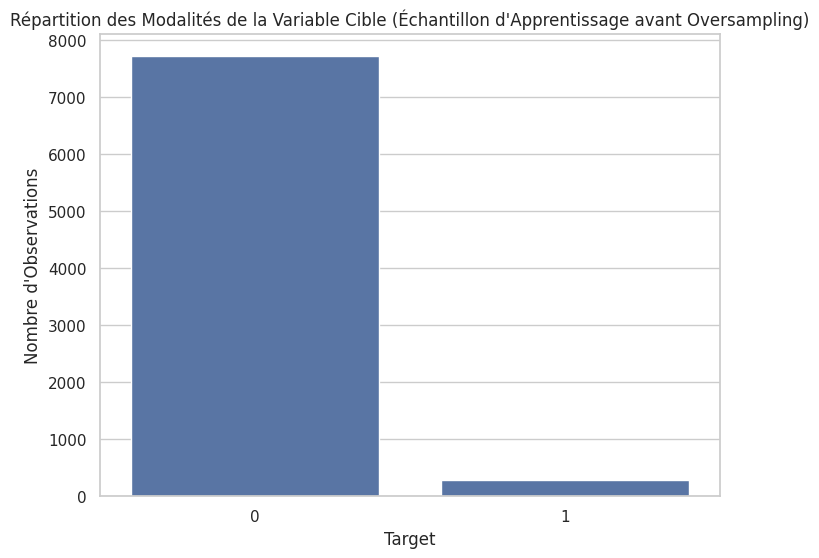

In [42]:
# Tracer un diagramme à barres pour la répartition des modalités de la variable cible
plt.figure(figsize=(8, 6))
sns.countplot(x='Target', data=train_base_b)
plt.title('Répartition des Modalités de la Variable Cible (Échantillon d\'Apprentissage avant Oversampling)')
plt.xlabel('Target')
plt.ylabel('Nombre d\'Observations')
plt.show()

Il y a un déséquilibre entre les deux classes. Nous allons réajuster la classe minoritaire par oversampling.

In [43]:
# Redressage de l'échantillon train_base_b par oversampling
oversampler = RandomOverSampler(random_state=42)
X_train_resampled_b, y_train_resampled_b = oversampler.fit_resample(X_train_b, y_train_b)

In [44]:
# Concaténation des données resamplées pour créer un DataFrame avec la variable cible
resampled_base_b = pd.DataFrame(X_train_resampled_b.copy(), columns=X_train_b.columns)
resampled_base_b['Target'] = y_train_resampled_b
resampled_base_b

,Type,Air_temperature,Process_temperature,Rotational_speed,Torque,Tool_wear,Target
0,1,-0.871408,-0.625417,0.798952,-1.107523,1.400674,0
1,1,-0.922704,-1.109223,-0.997996,1.497236,0.466708,0
2,1,-0.922704,-1.523914,0.105393,-1.107523,1.384571,0
3,2,0.462283,0.549542,0.664969,-0.889504,-1.626665,0
4,1,0.718762,0.342196,0.444292,-0.786231,1.610012,0
...,...,...,...,...,...,...,...
15439,1,1.283016,0.134851,-1.462996,1.130046,0.643839,1
15440,0,1.898565,1.309809,-1.439352,1.371015,-0.676596,1
15441,1,1.283016,0.273081,-1.305369,1.646408,1.271851,1
15442,2,1.693382,1.033348,-1.116216,0.751380,-0.773213,1


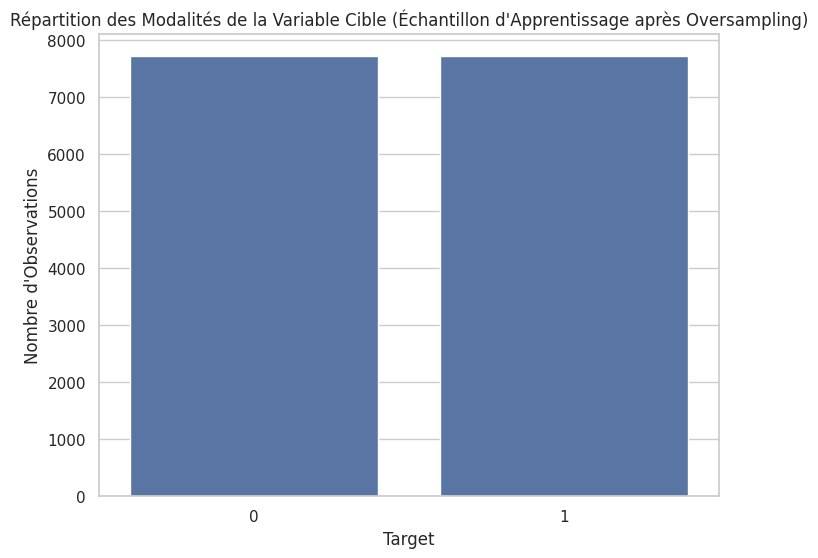

In [45]:
# Tracer un diagramme à barres pour la répartition des modalités de la variable cible
plt.figure(figsize=(8, 6))
sns.countplot(x='Target', data=resampled_base_b)
plt.title('Répartition des Modalités de la Variable Cible (Échantillon d\'Apprentissage après Oversampling)')
plt.xlabel('Target')
plt.ylabel('Nombre d\'Observations')
plt.show()

L'échantillon est bien rééquilibré. Il n'y a pas de classe majoritaire ou minoritaire.

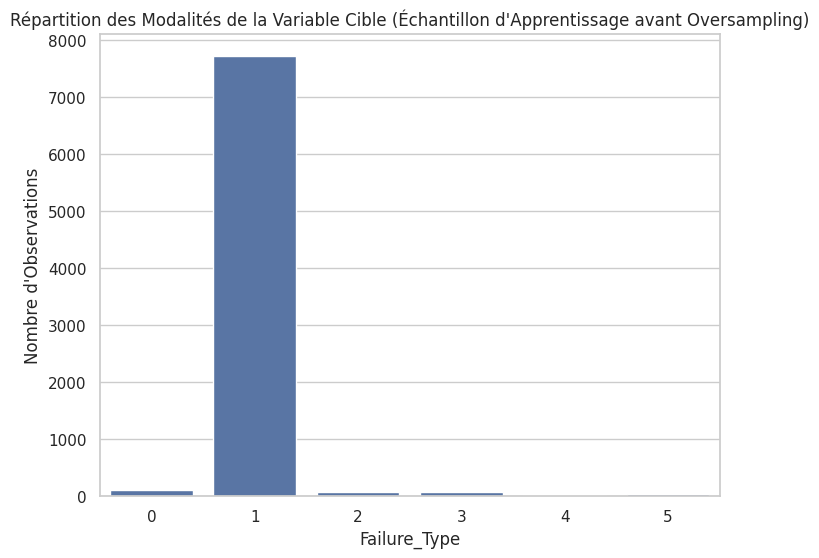

In [46]:
# Tracer un diagramme à barres pour la répartition des modalités de la variable cible
plt.figure(figsize=(8, 6))
sns.countplot(x='Failure_Type', data=train_base_m)
plt.title('Répartition des Modalités de la Variable Cible (Échantillon d\'Apprentissage avant Oversampling)')
plt.xlabel('Failure_Type')
plt.ylabel('Nombre d\'Observations')
plt.show()

Comme pour la variable Target, il y a également un déséqulibre entre les différentes modalité de la variable catégorielle.

In [47]:
# Redressage de l'échantillon train_base_m par oversampling
oversampler = RandomOverSampler(random_state=42)
X_train_resampled_m, y_train_resampled_m = oversampler.fit_resample(X_train_m, y_train_m)

In [48]:
# Concaténation des données resamplées pour créer un DataFrame avec la variable cible
resampled_base_m = pd.DataFrame(X_train_resampled_m.copy(), columns=X_train_m.columns)
resampled_base_m['Failure_Type'] = y_train_resampled_m
resampled_base_m

,Type,Air_temperature,Process_temperature,Rotational_speed,Torque,Tool_wear,Failure_Type
0,1,-0.871408,-0.625417,0.798952,-1.107523,1.400674,1
1,1,-0.922704,-1.109223,-0.997996,1.497236,0.466708,1
2,1,-0.922704,-1.523914,0.105393,-1.107523,1.384571,1
3,2,0.462283,0.549542,0.664969,-0.889504,-1.626665,1
4,1,0.718762,0.342196,0.444292,-0.786231,1.610012,1
...,...,...,...,...,...,...,...
46297,1,0.513579,0.411311,-0.170454,-0.338717,1.577806,5
46298,1,0.410987,0.411311,0.491580,-0.327243,1.915966,5
46299,1,0.051916,0.065735,-0.091640,-0.074799,-0.000275,5
46300,0,1.334312,1.033348,0.901410,-0.728858,1.932069,5


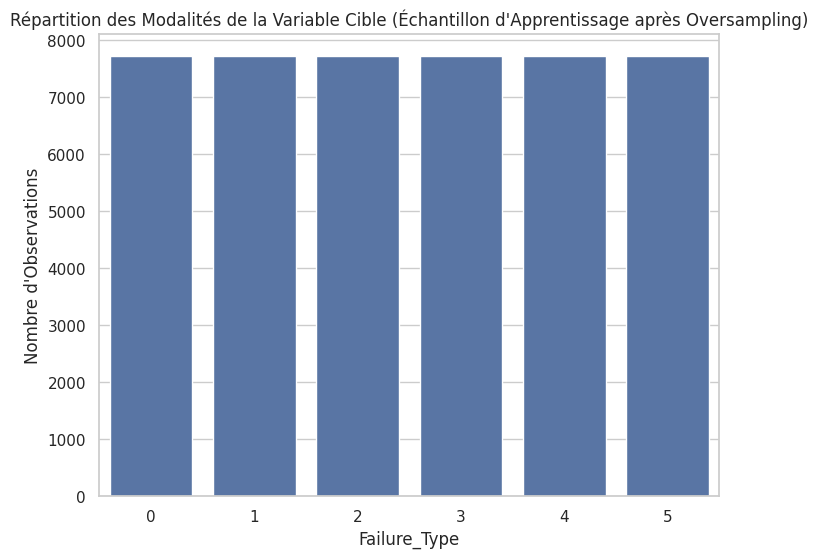

In [49]:
# Tracer un diagramme à barres pour la répartition des modalités de la variable cible
plt.figure(figsize=(8, 6))
sns.countplot(x='Failure_Type', data=resampled_base_m)
plt.title('Répartition des Modalités de la Variable Cible (Échantillon d\'Apprentissage après Oversampling)')
plt.xlabel('Failure_Type')
plt.ylabel('Nombre d\'Observations')
plt.show()

L'échantillon est bien rééquilibré.

In [50]:
resampled_base_m.shape

(46302, 7)

Il y a trop d'observation. Le temps de calcul des modèles risque d'être long. Nous allons réduire l'échantillon train de 46302 à 8000 observations.

In [51]:
# Utiliser train_test_split avec stratify pour conserver la proportion des classes
df_train, df_remainder = train_test_split(resampled_base_m, test_size=38302, random_state=42, stratify=resampled_base_m['Failure_Type'])
df_train

,Type,Air_temperature,Process_temperature,Rotational_speed,Torque,Tool_wear,Failure_Type
41439,1,2.257636,2.553883,-0.044352,-0.660009,1.561703,5
20042,2,0.257100,0.756887,-1.723081,2.357840,1.513394,2
33179,1,0.359691,0.687772,-0.800962,1.290692,-0.274024,4
24240,1,0.051916,0.065735,-0.091640,-0.074799,-0.000275,3
46088,1,1.129128,0.895118,0.121156,-0.396091,1.593909,5
...,...,...,...,...,...,...,...
486,1,1.334312,1.448039,-0.745793,1.244793,1.191337,1
45608,2,-0.358450,-1.109223,0.215732,-0.373142,1.529497,5
41167,2,-0.820112,-1.385684,-0.777318,-0.292819,1.448983,5
28469,1,1.077833,0.826003,-0.477827,2.116871,0.724354,3


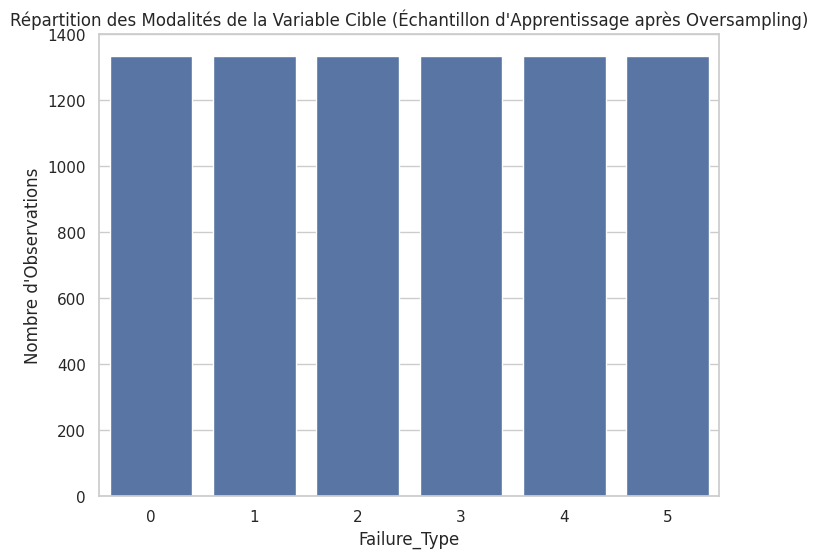

In [52]:
# Tracer un diagramme à barres pour la répartition des modalités de la variable cible
plt.figure(figsize=(8, 6))
sns.countplot(x='Failure_Type', data=df_train)
plt.title('Répartition des Modalités de la Variable Cible (Échantillon d\'Apprentissage après Oversampling)')
plt.xlabel('Failure_Type')
plt.ylabel('Nombre d\'Observations')
plt.show()

Les modalités de la variable cible sont toujours à l'équilibre.

In [53]:
X_df_train_m = df_train.drop('Failure_Type', axis=1)
y_df_train_m = df_train['Failure_Type']

##**Modélisation**

##**Modèles SVM**

###**Classification binaire**

####Modélisation avec paramètres par défaut

In [141]:
#SVC
c_svc = SVC(random_state=42)
scores_1 = cross_val_score(c_svc, X_train_resampled_b, y_train_resampled_b, cv=5, error_score='raise')
print("Précision moyenne:", scores_1.mean())

Précision moyenne: 0.9171841374289851


Les paramètres par défaut sont : SVC(C=1.0, kernel='rbf', gamma='scale')

In [142]:
#LinearSVC
l_SVC = LinearSVC(random_state=42)
scores_2 = cross_val_score(l_SVC, X_train_resampled_b, y_train_resampled_b, cv=5)
print("Précision moyenne:", scores_2.mean())

Précision moyenne: 0.7452080296623318


Les paramètres par défaut sont:
C (paramètre de régularisation) : 1.0
loss (fonction de perte) : 'squared_hinge'

In [143]:
#SGD classifier
sgdc_svm = SGDClassifier(random_state=42)
scores_3 = cross_val_score(sgdc_svm, X_train_resampled_b, y_train_resampled_b, cv=5)
print("Précision moyenne:", scores_3.mean())

Précision moyenne: 0.7405463897466693


Les paramètres par défaut sont les suivant:
-loss (fonction de perte) : 'hinge'
-penalty (terme de pénalité) : 'l2'
-alpha (termes de régularisation) : 0.0001
-l1_ratio (mélange de régularisation L1 et L2) : 0.15
-max_iter (nombre maximal d'itérations) : 1000

In [144]:
#Regroupement des résultats des cross validation des différents modèle
df_cross = pd.DataFrame(np.transpose(np.c_[scores_1, scores_2, scores_3]),
                        columns=['fold1','fold2','fold3','fold4','fold5'])
#Adding model label
df_cross['modèle'] = ['SVC','LinearSVC','SGDClassifier']
df_cross

,fold1,fold2,fold3,fold4,fold5,modèle
0,0.917125,0.906118,0.921010,0.932664,0.909003,SVC
1,0.750081,0.753966,0.740369,0.743606,0.738018,LinearSVC
2,0.737779,0.748139,0.715118,0.762706,0.738990,SGDClassifier


On regroupe les résultats des cross-validation des trois modèles pour vérifier quel est le meilleur modèle.

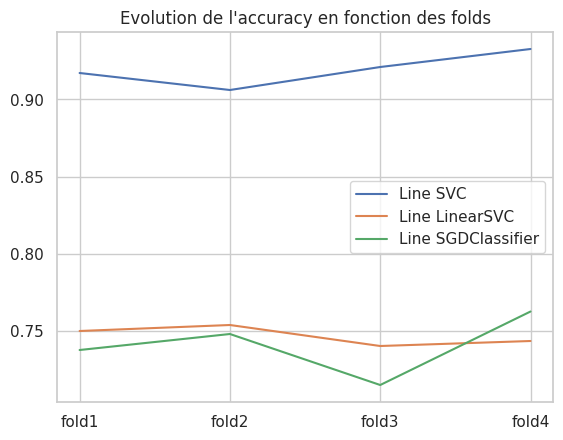

In [145]:
#Graphique de l'évolution des scores
for row in range(df_cross.shape[0]):
    plt.plot( df_cross.iloc[row,0:4] ,label='Line '+str(df_cross.iloc[row,5]))

plt.legend()
plt.title("Evolution de l'accuracy en fonction des folds")
plt.show()

Le modèle SVC a un bien meilleur score sur les différents fold que les deux autres modèles.

In [146]:
for i in range(3):

    mean_model = df_cross.iloc[:,0:5].mean(axis=1)[i]
    std_model = df_cross.iloc[:,0:5].std(axis=1)[i]

    print('Le modèle N° '+ str(i) + ' a une accuray de '  + str(mean_model) + ' et un std : ' + str(std_model))

Le modèle N° 0 a une accuray de 0.9171841374289851 et un std : 0.01053164918930798
Le modèle N° 1 a une accuray de 0.7452080296623318 et un std : 0.006673031447086026
Le modèle N° 2 a une accuray de 0.7405463897466693 et un std : 0.017359302826252147


**Choix du modèle :**

Le modèle retenu est le SVC car il dispose du meilleur score de précision (92% de bonnes prédictions). De même sa variance semble correcte ce qui prouve que le modèle est plutôt stable. Il a donc moins de chance d'être under ou overfitting.


####Tunage du meilleur modèle

In [147]:
# Définition du modèle SVC
c_svc = SVC(random_state=42)

#Tunage de trois kernels
#params = [
#    {"kernel": ["rbf"], "gamma": [0.01, 0.1,0.5,1,2], "C": [1, 10, 100, 1000]},
#    {"kernel": ["poly"], "degree":[1,2,3,4],"C": [1, 10, 100, 1000]},
#    {"kernel": ["linear"],"C": [1, 10, 100, 1000]}
#]

params = {
    "kernel" : ['linear','poly', 'rbf'],
    "C" : [0.5, 1, 10, 50,100,1000]
        }

# Recherche d'hyperparamètres avec GridSearchCV et validation croisée
grid_search = GridSearchCV(estimator=c_svc, param_grid=params, cv=5, scoring='accuracy')
# plus de 2h de calcul
grid_search.fit(X_train_resampled_b, y_train_resampled_b)

GridSearchCV(cv=5, estimator=SVC(random_state=42),
             param_grid={'C': [0.5, 1, 10, 50, 100, 1000],
                         'kernel': ['linear', 'poly', 'rbf']},
             scoring='accuracy')

On réalise l'optimisation du modèle SVC avec les paramètres du type de noyau utilisé et du coefficient de régularisation.

In [148]:
# Affichage des meilleurs paramètres
best_params = grid_search.best_params_
best_score = grid_search.best_score_
print("Meilleurs paramètres :", best_params)# Meilleur paramètres
print("Meilleur score : ", best_score) # Meilleur score

Meilleurs paramètres : {'C': 1000, 'kernel': 'rbf'}
Meilleur score :  0.9673010280503945


Le modèle retenu est un modèle avec comme paramètre de régularisation de 1000 pour un type de noyau 'rbf'. Le score d'accuracy est de 97% de précision, ce qui est plus que le modèle par défaut.

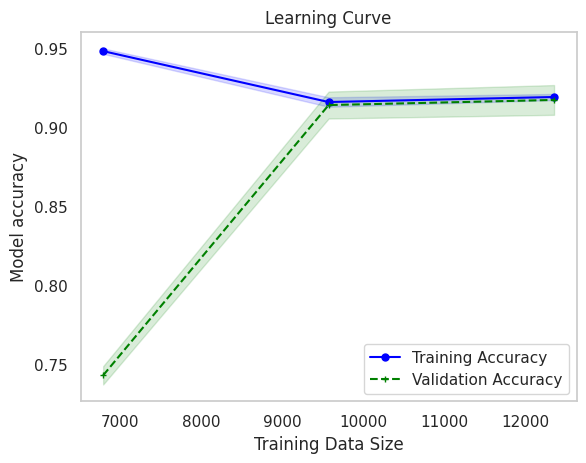

In [149]:
from sklearn.model_selection import learning_curve
from sklearn.model_selection import ShuffleSplit
train_sizes, train_scores, test_scores = learning_curve(estimator=c_svc,
                                                        X=X_train_resampled_b,
                                                        y=y_train_resampled_b,
                                                        cv=5,
                                                        train_sizes=np.linspace(0.1, 1.0, 5),
                                                        random_state=42
                                                       )

#
# Trop de fluctuation dans le modèle, on calcule la moyenne des métriques
#
train_mean = np.mean(train_scores, axis=1)
train_std = np.std(train_scores, axis=1)
test_mean = np.mean(test_scores, axis=1)
test_std = np.std(test_scores, axis=1)
#
# Plot the learning curve
#
plt.plot(train_sizes, train_mean, color='blue', marker='o', markersize=5, label='Training Accuracy')
plt.fill_between(train_sizes, train_mean + train_std, train_mean - train_std, alpha=0.15, color='blue')
plt.plot(train_sizes, test_mean, color='green', marker='+', markersize=5, linestyle='--', label='Validation Accuracy')
plt.fill_between(train_sizes, test_mean + test_std, test_mean - test_std, alpha=0.15, color='green')
plt.title('Learning Curve')
plt.xlabel('Training Data Size')
plt.ylabel('Model accuracy')
plt.grid()
plt.legend(loc='lower right')
plt.show()

On voit que le modèle arrête d'apprendre à partir d'environ 9500 observations.

In [150]:
best_svc_b = SVC(C=1000, kernel='rbf')
best_svc_b.fit(X_train_resampled_b, y_train_resampled_b)

SVC(C=1000)

Précision sur l'échantillon de test : 0.934


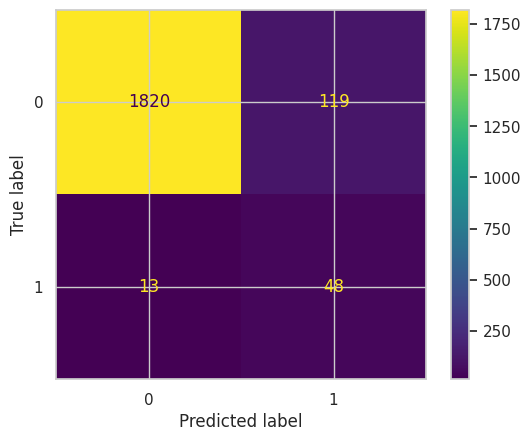

In [151]:
# Prédiction sur l'échantillon d'entraînement et de test
y_test_pred_b = best_svc_b.predict(X_test_b)

# Évaluation de la précision du modèle
test_accuracy_b = accuracy_score(y_test_b, y_test_pred_b)

print("Précision sur l'échantillon de test :", test_accuracy_b)

# On calcule la matrice de confusion
ConfusionMatrixDisplay.from_estimator(best_svc_b, X_test_b, y_test_b)

On peut voir que les scores sont presque semblables, il n'y a donc pas de suspicion d'overfitting. Le modèle peut donc être généralisé.

####Importance des variables

In [152]:
from sklearn.inspection import permutation_importance

# Calcul de l'importance des caractéristiques par permutation
perm_importance = permutation_importance(best_svc_b, X_test_b, y_test_b, n_repeats=30, random_state=42)

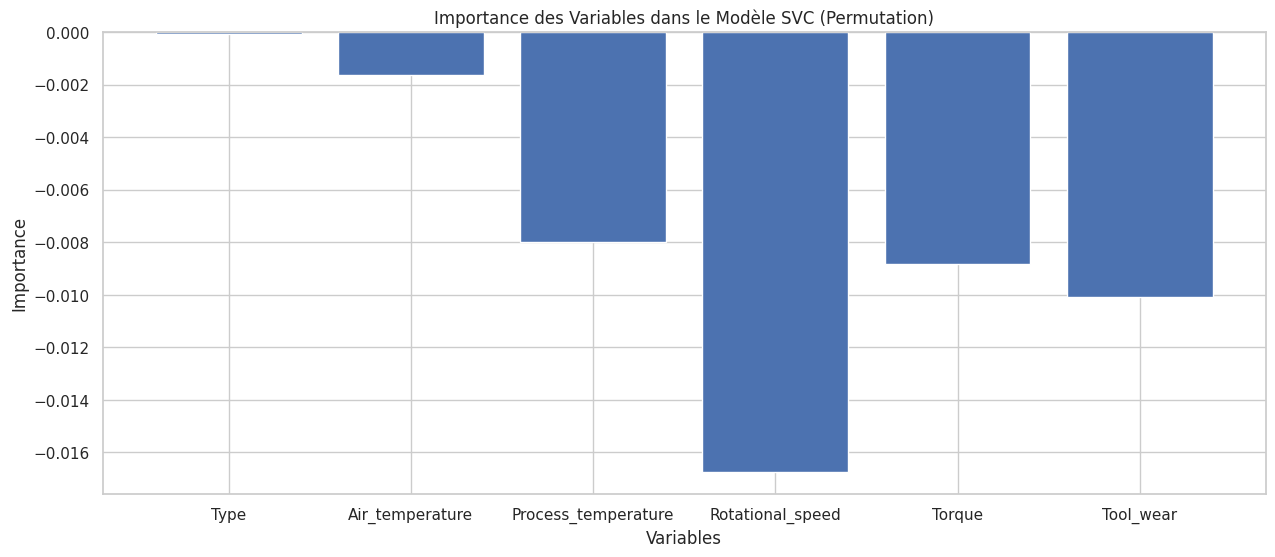

In [153]:
# Affichage des importances des caractéristiques
features = X_train_resampled_b.columns

# Tracer un graphique d'importance des caractéristiques
plt.figure(figsize=(15, 6))
plt.bar(features, perm_importance.importances_mean)
plt.xticks(features)
plt.xlabel('Variables')
plt.ylabel('Importance')
plt.title('Importance des Variables dans le Modèle SVC (Permutation)')
plt.show()

On peut voir d'après le graphique ci-dessus, la représentation des variables les plus importantes. On retrouve le nombre de rotation par minute, l'usure de l'outil, le couple et la température du processus.

###Classification multiclasse

In [154]:
#SVC multiclasse
c_svc = SVC(random_state=42)
scores = cross_val_score(c_svc, X_df_train_m, y_df_train_m, cv=5, error_score='raise')
print("Précision moyenne:", scores.mean())

Précision moyenne: 0.9305


La précision est plutôt bonne. Nous allons essayer du tuner le modèle avec un gridsearch.

In [155]:
# Définition du modèle SVC
c_svc = SVC(random_state=42)

#Définition des paramètres à optimiser
param_grid = {'C': [0.1, 1, 10, 100],
               'kernel': ['linear', 'poly', 'rbf'],
                 'decision_function_shape': ['ovo', 'ovr']
                 }

# Recherche d'hyperparamètres avec GridSearchCV et validation croisée
grid_search = GridSearchCV(estimator=c_svc, param_grid=param_grid, cv=5, scoring='accuracy')
# 6 min de calcul
grid_search.fit(X_df_train_m, y_df_train_m)

GridSearchCV(cv=5, estimator=SVC(random_state=42),
             param_grid={'C': [0.1, 1, 10, 100],
                         'decision_function_shape': ['ovo', 'ovr'],
                         'kernel': ['linear', 'poly', 'rbf']},
             scoring='accuracy')

On réalise un grid search avec les paramètres du coefficient de régularisation, le types de noyau et s'il faut choisir entre une classification One vs One ou One vs Rest.

In [156]:
# Affichage des meilleurs paramètres
best_params = grid_search.best_params_
best_score = grid_search.best_score_
print("Meilleurs paramètres :", best_params)# Meilleur paramètres
print("Meilleur score : ", best_score) # Meilleur score

Meilleurs paramètres : {'C': 100, 'decision_function_shape': 'ovo', 'kernel': 'rbf'}
Meilleur score :  0.9574999999999999


Le modèle retenu utilise un coefficient de régularisation de 100 pour un kernel 'rbf'. La classification est un One vs One.

Le score de précision est légèrement mieux que le modèle par défaut.

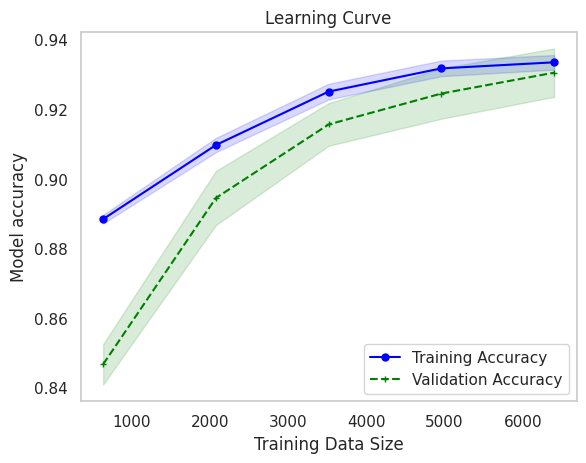

In [157]:
from sklearn.model_selection import learning_curve
from sklearn.model_selection import ShuffleSplit
train_sizes, train_scores, test_scores = learning_curve(estimator=c_svc,
                                                        X=X_df_train_m,
                                                        y=y_df_train_m,
                                                        cv=5,
                                                        train_sizes=np.linspace(0.1, 1.0, 5),
                                                        random_state=42
                                                       )

#
# Trop de fluctuation dans le modèle, on calcule la moyenne des métriques
#
train_mean = np.mean(train_scores, axis=1)
train_std = np.std(train_scores, axis=1)
test_mean = np.mean(test_scores, axis=1)
test_std = np.std(test_scores, axis=1)
#
# Plot the learning curve
#
plt.plot(train_sizes, train_mean, color='blue', marker='o', markersize=5, label='Training Accuracy')
plt.fill_between(train_sizes, train_mean + train_std, train_mean - train_std, alpha=0.15, color='blue')
plt.plot(train_sizes, test_mean, color='green', marker='+', markersize=5, linestyle='--', label='Validation Accuracy')
plt.fill_between(train_sizes, test_mean + test_std, test_mean - test_std, alpha=0.15, color='green')
plt.title('Learning Curve')
plt.xlabel('Training Data Size')
plt.ylabel('Model accuracy')
plt.grid()
plt.legend(loc='lower right')
plt.show()

Le training Accuracy et la Validation Accuracy converge jusqu'à avoir pratiquement le même score. 8000 observations semble donc être un bon compromis. Il n'y a pas de suspicion de overfitting.

In [158]:
best_svc_m = SVC(C=100, kernel='rbf', decision_function_shape = 'ovo' )
best_svc_m.fit(X_df_train_m, y_df_train_m)

SVC(C=100, decision_function_shape='ovo')

Précision sur l'échantillon de test : 0.9035


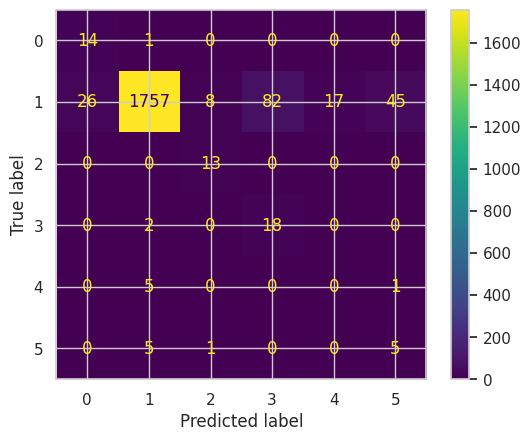

In [159]:
from sklearn.metrics import accuracy_score, roc_curve, roc_auc_score,\
    confusion_matrix, classification_report,ConfusionMatrixDisplay

# Prédiction sur l'échantillon d'entraînement et de test
y_test_pred_m = best_svc_m.predict(X_test_m)

# Évaluation de la précision du modèle
test_accuracy_m = accuracy_score(y_test_m, y_test_pred_m)

print("Précision sur l'échantillon de test :", test_accuracy_m)

# On calcule la matrice de confusion
ConfusionMatrixDisplay.from_estimator(best_svc_m, X_test_m, y_test_m)

Le score de précision de l'échantillon test est de 90%. Il est proche de celui de l'échantillon apprentissage mais pourrait être amélioré en augmentant la taille de l'échantillon ou en enlevant ou en rajoutant d'autres paramètres à optimiser dans le gridsearch. La non présence d'échecs est la modalité la mieux prédite.

Importance des variables

In [160]:
from sklearn.inspection import permutation_importance

# Calcul de l'importance des caractéristiques par permutation
perm_importance = permutation_importance(best_svc_m, X_test_m, y_test_m, n_repeats=30, random_state=42)

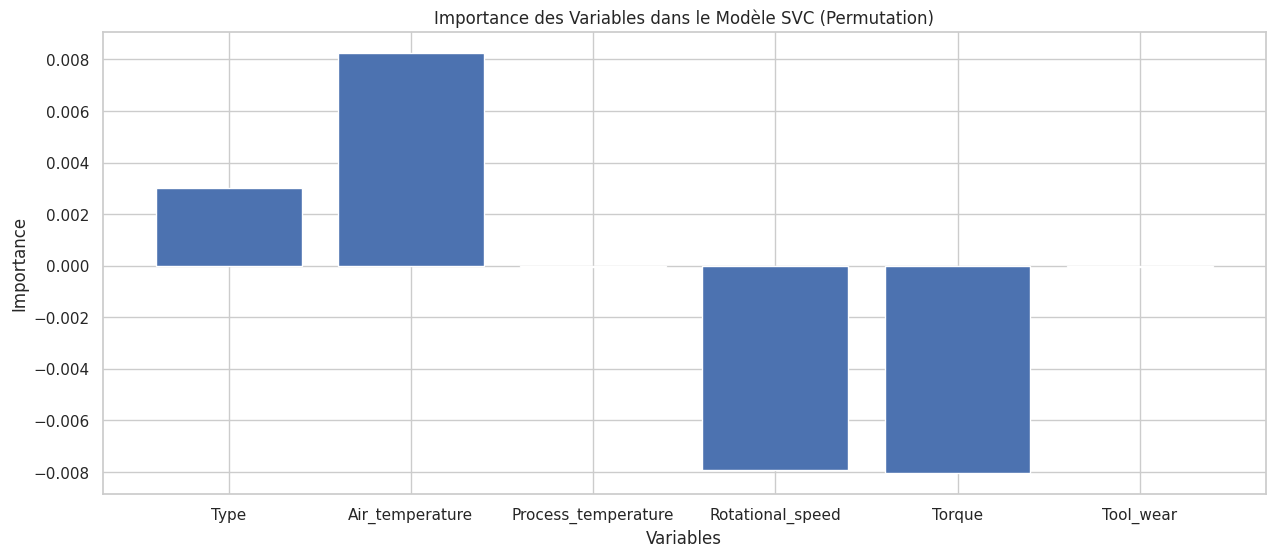

In [161]:
# Affichage des importances des caractéristiques
features = X_df_train_m.columns

# Tracer un graphique d'importance des caractéristiques
plt.figure(figsize=(15, 6))
plt.bar(features, perm_importance.importances_mean)
plt.xticks(features)
plt.xlabel('Variables')
plt.ylabel('Importance')
plt.title('Importance des Variables dans le Modèle SVC (Permutation)')
plt.show()

En effet positif important, il y a la température de l'air et la qualité de la machine. Et en effet négatif, ce sont le couple et le nombre de tour qui sont les plus importantes.

###**Réseau de Neurones**

####ANN pour classification binaire

Définition d'un premier modèle par défaut.

In [54]:
X_train_resampled_b.shape

(15444, 6)

In [55]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense

In [56]:
model = Sequential()

# Couche d'entrée avec 6 neurones correspondant aux variables explicatives
model.add(Dense(6, input_dim=6, activation='relu'))

# Couche cachée avec 12 neurones et activation relu
model.add(Dense(100, activation='relu'))

# Couche de sortie avec 1 neurone et activation sigmoid pour la classification binaire
model.add(Dense(1, activation='sigmoid'))

# Compiler le modèle
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

In [57]:
history = model.fit(X_train_resampled_b, y_train_resampled_b, epochs=50, batch_size=32, validation_split=0.2)

Epoch 1/50
387/387 [==============================] - 2s 2ms/step - loss: 0.4911 - accuracy: 0.7216 - val_loss: 0.6573 - val_accuracy: 0.6339
Epoch 2/50
387/387 [==============================] - 1s 2ms/step - loss: 0.4216 - accuracy: 0.7609 - val_loss: 0.5549 - val_accuracy: 0.6523
Epoch 3/50
387/387 [==============================] - 1s 2ms/step - loss: 0.3947 - accuracy: 0.7809 - val_loss: 0.5529 - val_accuracy: 0.6293
Epoch 4/50
387/387 [==============================] - 1s 2ms/step - loss: 0.3705 - accuracy: 0.7969 - val_loss: 0.4935 - val_accuracy: 0.6452
Epoch 5/50
387/387 [==============================] - 1s 2ms/step - loss: 0.3468 - accuracy: 0.8422 - val_loss: 0.4438 - val_accuracy: 0.8618
Epoch 6/50
387/387 [==============================] - 1s 2ms/step - loss: 0.3239 - accuracy: 0.8642 - val_loss: 0.3312 - val_accuracy: 0.9178
Epoch 7/50
387/387 [==============================] - 1s 2ms/step - loss: 0.3022 - accuracy: 0.8758 - val_loss: 0.3592 - val_accuracy: 0.9081
Epoch 

In [61]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 6)                 42        
                                                                 
 dense_1 (Dense)             (None, 100)               700       
                                                                 
 dense_2 (Dense)             (None, 1)                 101       
                                                                 
Total params: 843 (3.29 KB)
Trainable params: 843 (3.29 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


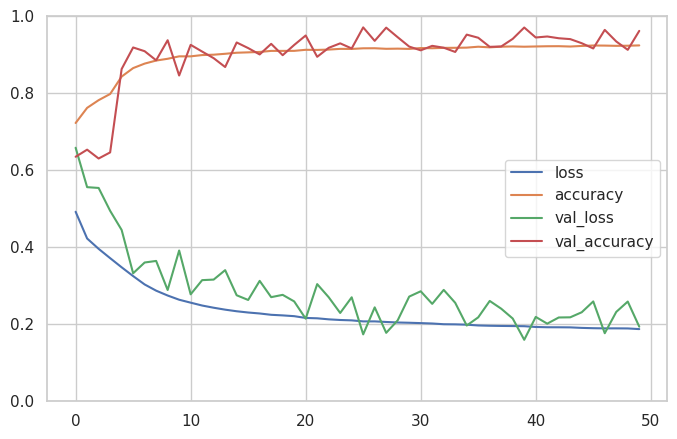

In [58]:
#Data to pandas dataframe
pd.DataFrame(history.history).plot(figsize=(8, 5))
plt.grid(True)
plt.gca().set_ylim(0, 1)
plt.show()

On voit qu'au fur et à mesure des epochs, le score d'accuracy augmente et se stabilise aux alentours de 96%. De même pour la fonction de perte qui diminue jusqu'à se stabiliser à 20%. 50 epochs semblent donc un bon compromis pour l'apprentissage du modèle. L'accuracy étant élevé pour une fonction de perte assez faible.

In [66]:
from sklearn.metrics import accuracy_score, roc_curve, roc_auc_score,\
    confusion_matrix, classification_report,ConfusionMatrixDisplay

y_pred_bn = (model.predict(X_test_b)>0.5).astype(int)
accuracy_bn = accuracy_score(y_test_b, y_pred_bn)
print(f"Accuracy on test set: {accuracy_bn:.2f}")

# Matrice de confusion
confusion_mat_bn = confusion_matrix(y_test_b, y_pred_bn)
print('Confusion Matrix:\n', confusion_mat_bn)

# Rapport de classification
class_report_bn = classification_report(y_test_b, y_pred_bn)
print('Classification Report:\n', class_report_bn)

63/63 [==============================] - 0s 1ms/step
Accuracy on test set: 0.90
Confusion Matrix:
 [[1759  180]
 [  13   48]]
Classification Report:
               precision    recall  f1-score   support

           0       0.99      0.91      0.95      1939
           1       0.21      0.79      0.33        61

    accuracy                           0.90      2000
   macro avg       0.60      0.85      0.64      2000
weighted avg       0.97      0.90      0.93      2000



Le score d'accuracy de l'échantillon test est pratiquement semblable à celui de l'apprentissage. Ceci prouve que le modèle n'a pas surappris et peut être généralisé.

Tunage du modèle

In [67]:
!pip install tensorflow==2.12.0

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 585.9/585.9 MB 2.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.7/1.7 MB 34.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.6/5.6 MB 30.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 440.7/440.7 kB 39.7 MB/s eta 0:00:00
  Attempting uninstall: tensorflow-estimator
    Found existing installation: tensorflow-estimator 2.15.0
    Uninstalling tensorflow-estimator-2.15.0:
      Successfully uninstalled tensorflow-estimator-2.15.0
  Attempting uninstall: keras
    Found existing installation: keras 2.15.0
    Uninstalling keras-2.15.0:
      Successfully uninstalled keras-2.15.0
  Attempting uninstall: gast
    Found existing installation: gast 0.5.4
    Uninstalling gast-0.5.4:
      Successfully uninstalled gast-0.5.4
  Attempting uninstall: google-auth-oauthlib
    Found existing installation: google-auth-oauthlib 1.2.0
    Uninstalling google-auth-oauthlib-1.2.0:
      Successfully un

In [ ]:
import tensorflow as tf
from tensorflow import keras
from keras.wrappers.scikit_learn import KerasClassifier
from sklearn.model_selection import GridSearchCV
from keras.models import Sequential
from keras.layers import Dense

In [86]:
# Fonction pour créer un modèle Keras (wrapper pour scikit-learn)
def create_model(num_layers, num_neurons, optimizer):
    model_1 = Sequential()
    model_1.add(Dense(num_neurons, input_dim=6, activation='relu'))
    for _ in range(num_layers - 1):
        model_1.add(Dense(num_neurons, activation='relu'))
    model_1.add(Dense(1, activation='sigmoid'))
    model_1.compile(optimizer=optimizer, loss= 'binary_crossentropy', metrics=['accuracy'])
    return model_1

In [82]:
# Créer le modèle wrapper
model_b = KerasClassifier(build_fn=create_model, epochs=10, batch_size=32, verbose=0)

# Définir les paramètres à optimiser dans la recherche sur grille
param_grid = {
    'num_layers': [1, 2, 3],          # Nombre de couches cachées
    'num_neurons': [8, 16, 32],       # Nombre de neurones par couche
    'optimizer': ['adam', 'rmsprop']  # optimizer
}

# Réaliser la recherche sur grille
grid_search = GridSearchCV(estimator=model_b, param_grid=param_grid, cv=3, scoring='accuracy')
grid_result = grid_search.fit(X_train_resampled_b, y_train_resampled_b, error_score='raise')

<ipython-input-82-50d5887c662c>:2: DeprecationWarning: KerasClassifier is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
  model_b = KerasClassifier(build_fn=create_model, epochs=10, batch_size=32, verbose=0)


ValueError: 
All the 54 fits failed.
It is very likely that your model is misconfigured.
You can try to debug the error by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
54 fits failed with the following error:
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_validation.py", line 686, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/usr/local/lib/python3.10/dist-packages/keras/wrappers/scikit_learn.py", line 248, in fit
    return super().fit(x, y, **kwargs)
  File "/usr/local/lib/python3.10/dist-packages/keras/wrappers/scikit_learn.py", line 167, in fit
    losses.is_categorical_crossentropy(self.model.loss)
AttributeError: module 'keras.losses' has no attribute 'is_categorical_crossentropy'


Le gridsearch n'a pas pu fonctionner car les versions des packages keras et scikit-learn sont incompatibles.

####ANN pour une classification multiclasses

Définition du modèle par défaut

In [120]:
model_mn = Sequential()
model_mn.add(Dense(6, input_dim=6, activation='relu'))
model_mn.add(Dense(100, activation='relu'))
model_mn.add(Dense(6, activation='softmax'))

# Compilation du modèle
model_mn.compile(loss='sparse_categorical_crossentropy', optimizer='adam', metrics=['accuracy'])


In [121]:
history_mn = model_mn.fit(X_df_train_m, y_df_train_m, epochs=50, batch_size=32, validation_split=0.2)

Epoch 1/50
200/200 [==============================] - 4s 10ms/step - loss: 1.3828 - accuracy: 0.4914 - val_loss: 1.0274 - val_accuracy: 0.6356
Epoch 2/50
200/200 [==============================] - 2s 11ms/step - loss: 0.8665 - accuracy: 0.7120 - val_loss: 0.8040 - val_accuracy: 0.7350
Epoch 3/50
200/200 [==============================] - 1s 6ms/step - loss: 0.7213 - accuracy: 0.7720 - val_loss: 0.7092 - val_accuracy: 0.7750
Epoch 4/50
200/200 [==============================] - 1s 6ms/step - loss: 0.6440 - accuracy: 0.7948 - val_loss: 0.6412 - val_accuracy: 0.8019
Epoch 5/50
200/200 [==============================] - 2s 8ms/step - loss: 0.5899 - accuracy: 0.8083 - val_loss: 0.5946 - val_accuracy: 0.7987
Epoch 6/50
200/200 [==============================] - 1s 5ms/step - loss: 0.5479 - accuracy: 0.8250 - val_loss: 0.5527 - val_accuracy: 0.8138
Epoch 7/50
200/200 [==============================] - 0s 2ms/step - loss: 0.5087 - accuracy: 0.8381 - val_loss: 0.5176 - val_accuracy: 0.8263
Epoc

In [122]:
model_mn.summary()

Model: "sequential_288"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_802 (Dense)           (None, 6)                 42        
                                                                 
 dense_803 (Dense)           (None, 100)               700       
                                                                 
 dense_804 (Dense)           (None, 6)                 606       
                                                                 
Total params: 1348 (5.27 KB)
Trainable params: 1348 (5.27 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


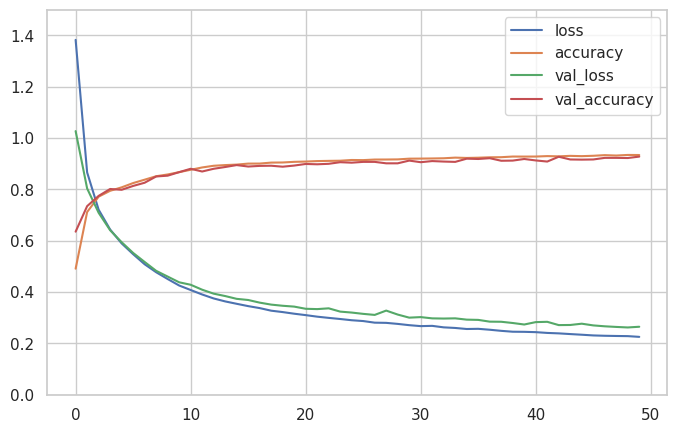

In [123]:
#Data to pandas dataframe
pd.DataFrame(history_mn.history).plot(figsize=(8, 5))
plt.grid(True)
plt.gca().set_ylim(0, 1.5)
plt.show()

l'accuracy se stabilise autour de 92% de précision. La fonction de perte diminue jusqu'à environ 22%. Le modèle semble donc performant.

In [138]:
test_loss, test_accuracy = model_mn.evaluate(X_test_m, y_test_m)
print("Précision sur l'ensemble de test : ", test_accuracy)


63/63 [==============================] - 0s 2ms/step - loss: 0.6130 - accuracy: 0.8015
Précision sur l'ensemble de test :  0.8015000224113464


l'accuracy de l'échantillon test est 80% bien moins que les 92% de l'échantillon train. Il y a une suspicion de surapprentissage.

Tunage du modèle

In [139]:
# Fonction pour créer un modèle Keras (wrapper pour scikit-learn)
def create_model(num_layers, num_neurons, optimizer):
    model_1 = Sequential()
    model_1.add(Dense(num_neurons, input_dim=6, activation='relu'))
    for _ in range(num_layers - 1):
        model_1.add(Dense(num_neurons, activation='relu'))
    model_1.add(Dense(6, activation='softmax'))
    model_1.compile(optimizer=optimizer, loss= 'sparse_categorical_crossentropy', metrics=['accuracy'])
    return model_1

In [140]:
# Créer le modèle wrapper
model_c = KerasClassifier(build_fn=create_model, epochs=10, batch_size=32, verbose=0)

# Définir les paramètres à optimiser dans la recherche sur grille
param_grid = {
    'num_layers': [1, 2, 3],          # Nombre de couches cachées
    'num_neurons': [8, 16, 32],       # Nombre de neurones par couche
    'optimizer': ['adam', 'rmsprop']  # optimizer
}

# Réaliser la recherche sur grille
grid_search = GridSearchCV(estimator=model_c, param_grid=param_grid, cv=3, scoring='accuracy')
grid_result = grid_search.fit(X_df_train_m, y_df_train_m, error_score='raise')

<ipython-input-140-7522a334fd34>:2: DeprecationWarning: KerasClassifier is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
  model_c = KerasClassifier(build_fn=create_model, epochs=10, batch_size=32, verbose=0)


ValueError: 
All the 54 fits failed.
It is very likely that your model is misconfigured.
You can try to debug the error by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
54 fits failed with the following error:
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_validation.py", line 686, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/usr/local/lib/python3.10/dist-packages/keras/wrappers/scikit_learn.py", line 248, in fit
    return super().fit(x, y, **kwargs)
  File "/usr/local/lib/python3.10/dist-packages/keras/wrappers/scikit_learn.py", line 167, in fit
    losses.is_categorical_crossentropy(self.model.loss)
AttributeError: module 'keras.losses' has no attribute 'is_categorical_crossentropy'


Même problème que pour la classification binaire.

##**Conclusion**

Que ce soit pour la classification binaire ou la classification multiclasse, le modèle le plus performant pour prédire les pannes de machines est le modèle SVC avec respectivement des scores pour l'échantillon test de 93.4% et 90.35%.